## Social graphs & intercations
- Project Assignment
- Submission date: December 9th 2025

### Group 96
- Aryan Mirzazadeh - s204489
- Juan Manuel Rodriguez - s253505 
- Vladyslav Horbatenko - s254355

### Contributions

- Aryan: Worked on Part 1
- Juan: Worked on Part 2
- Vlad: Worked on Part 3

---

In [1]:
import networkx as nx
import numpy as np
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize

# 1) Character network interaction analysis

## Create undirected weighted character interaction network

In [2]:
# Load data
DATA_DIR = Path("data")
with open(DATA_DIR / "character_connections_with_sentiment.json", "r") as f:
    character_data = json.load(f)

print(f"Loaded {len(character_data)} characters")

# Create undirected weighted graph
G = nx.Graph()

# Add nodes with sentiment as node attribute
for character, data in character_data.items():
    sentiment = data.get("sentiment")
    G.add_node(character, sentiment=sentiment)

# Add weighted edges
for character, data in character_data.items():
    connections = data.get("connections", {})
    for other_char, weight in connections.items():
        # Only add edge if both nodes exist (undirected, so we check to avoid duplicates)
        if G.has_node(other_char):
            if G.has_edge(character, other_char):
                # Update weight if edge exists (sum the weights from both directions)
                G[character][other_char]["weight"] += weight
            else:
                G.add_edge(character, other_char, weight=weight)

print("Network Statistics:")
print(f"  - Nodes: {G.number_of_nodes()}")
print(f"  - Edges: {G.number_of_edges()}")
print(f"  - Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

Loaded 113 characters
Network Statistics:
  - Nodes: 113
  - Edges: 313
  - Average degree: 5.54


***

## Network Visualization with ForceAtlas2 Layout

Visualizing the network using a force-directed layout with nodes colored by sentiment scores

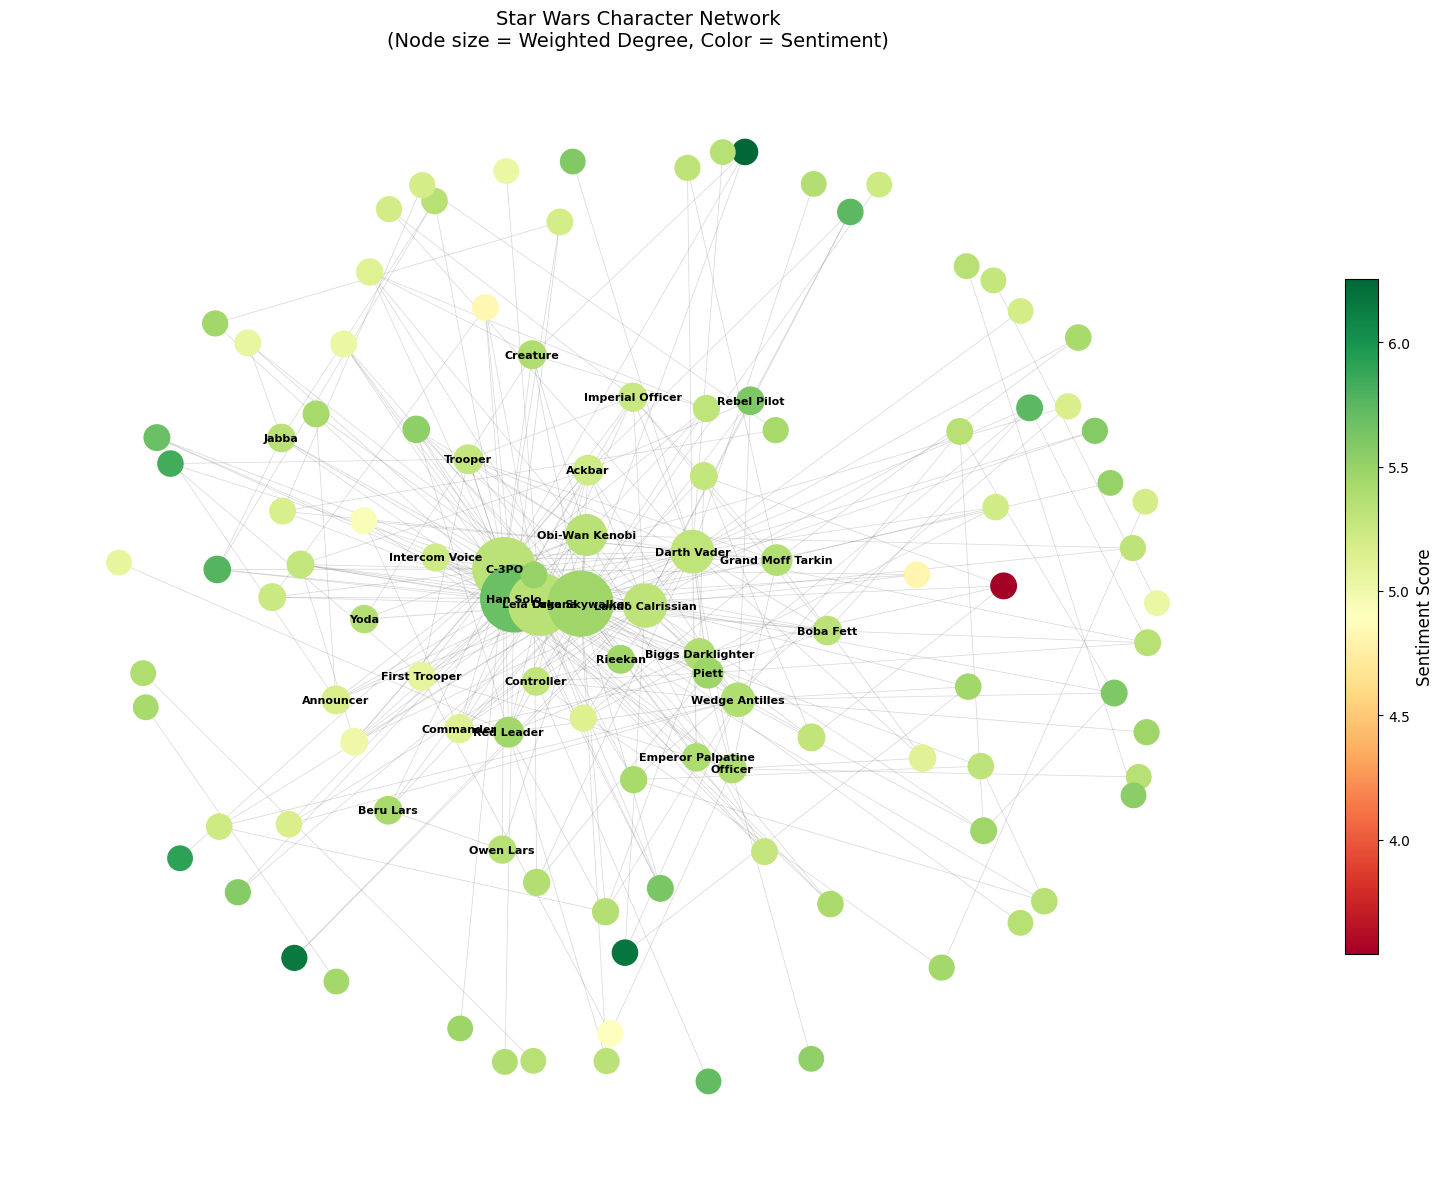

In [3]:
# Get sentiment values for coloring
sentiments = [G.nodes[n]["sentiment"] for n in G.nodes()]

# Replace None with median sentiment for visualization
valid_sentiments = [s for s in sentiments if s is not None]
median_sentiment = np.median(valid_sentiments)
sentiments_filled = [s if s is not None else median_sentiment for s in sentiments]

# Create color mapping
norm = Normalize(vmin=min(valid_sentiments), vmax=max(valid_sentiments))
cmap = cm.RdYlGn  # Red (negative) to Green (positive)
node_colors = [cmap(norm(s)) for s in sentiments_filled]

# Calculate node sizes based on degree
degrees = dict(G.degree(weight="weight"))
max_degree = max(degrees.values())
node_sizes = [300 + (degrees[n] / max_degree) * 2000 for n in G.nodes()]

# Use spring layout as ForceAtlas2 approximation (with weight consideration)
# NetworkX's spring_layout is similar to ForceAtlas2
pos = nx.spring_layout(G, k=2, iterations=100, seed=42, weight="weight")

# Visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Draw edges with varying alpha based on weight
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
max_weight = max(edge_weights)
edge_alphas = [0.1 + 0.5 * (w / max_weight) for w in edge_weights]

nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.3,
    width=[0.5 + 2 * (w / max_weight) for w in edge_weights],
    edge_color="gray",
    ax=ax,
)

# Draw nodes
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=sentiments_filled,
    node_size=node_sizes,
    cmap=cmap,
    vmin=min(valid_sentiments),
    vmax=max(valid_sentiments),
    ax=ax,
)

# Add labels for major characters (high degree)
degree_threshold = np.percentile(list(degrees.values()), 75)
labels = {n: n for n in G.nodes() if degrees[n] >= degree_threshold}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight="bold", ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label("Sentiment Score", fontsize=12)

ax.set_title(
    "Star Wars Character Network\n(Node size = Weighted Degree, Color = Sentiment)",
    fontsize=14,
)
ax.axis("off")
plt.tight_layout()
plt.show()

> Figure: Character interaction network, where node color is determined by the sentiment score. And most characters seem to have a neutral sentiment (around 5).

***

## Community Detection Analysis

### Approach 1) Sentiment-Based Communities

Grouping characters into communities based on their sentiment scores (low, medium, high sentiment).

In [4]:
# Sentiment-based community detection
# Use tertiles to create 3 sentiment-based communities

# Get valid sentiments and compute tertile thresholds
valid_sentiment_nodes = [
    (n, G.nodes[n]["sentiment"])
    for n in G.nodes()
    if G.nodes[n]["sentiment"] is not None
]
sentiment_values = sorted([s for _, s in valid_sentiment_nodes])

# Calculate tertile thresholds
tertile_1 = np.percentile(sentiment_values, 33.33)
tertile_2 = np.percentile(sentiment_values, 66.67)

print(f"Sentiment tertile thresholds: {tertile_1:.3f}, {tertile_2:.3f}")

# Assign nodes to sentiment-based communities
sentiment_communities = {0: set(), 1: set(), 2: set()}  # Low, Medium, High sentiment

for node in G.nodes():
    sentiment = G.nodes[node]["sentiment"]
    if sentiment is None:
        sentiment = median_sentiment  # Use median for missing values
    if sentiment <= tertile_1:
        sentiment_communities[0].add(node)
    elif sentiment <= tertile_2:
        sentiment_communities[1].add(node)
    else:
        sentiment_communities[2].add(node)

# Convert to list of sets for modularity calculation
sentiment_community_list = [sentiment_communities[i] for i in range(3)]

print("Sentiment-based communities:")
print(
    f"  - Low sentiment (≤{tertile_1:.3f}): {len(sentiment_communities[0])} characters"
)
print(
    f"  - Medium sentiment ({tertile_1:.3f}-{tertile_2:.3f}): {len(sentiment_communities[1])} characters"
)
print(
    f"  - High sentiment (>{tertile_2:.3f}): {len(sentiment_communities[2])} characters"
)

Sentiment tertile thresholds: 5.286, 5.430
Sentiment-based communities:
  - Low sentiment (≤5.286): 35 characters
  - Medium sentiment (5.286-5.430): 44 characters
  - High sentiment (>5.430): 34 characters


***

### Approach 2: Louvain Community Detection

Using NetworkX's Louvain algorithm which optimizes modularity to find communities based on network structure.

In [5]:
from networkx.algorithms.community import louvain_communities

# Louvain community detection
louvain_communities_result = louvain_communities(G, weight="weight", seed=42)
print(f"Louvain detected {len(louvain_communities_result)} communities:\n")
for i, community in enumerate(louvain_communities_result):
    # Top 5 members by degree count
    members_by_degree = sorted(community, key=lambda x: degrees[x], reverse=True)[:5]
    print(f"Community {i+1} ({len(community)} members): {', '.join(members_by_degree)}")

Louvain detected 9 communities:

Community 1 (22 members): Han Solo, C-3PO, Leia Organa, Rieekan, Announcer
Community 2 (18 members): Lando Calrissian, Wedge Antilles, Ackbar, Controller, Rebel Pilot
Community 3 (2 members): Second Commander, Control Room Commander
Community 4 (34 members): Darth Vader, Grand Moff Tarkin, Piett, Trooper, Boba Fett
Community 5 (2 members): Massassi Intercom Voice, Gold Five
Community 6 (4 members): Derlin, Hobbie, Pilots, Lieutenant
Community 7 (2 members): Rebel Fighter, Rebel Captain
Community 8 (27 members): Luke Skywalker, Obi-Wan Kenobi, Biggs Darklighter, Red Leader, Creature
Community 9 (2 members): Porkins, Red Nine


***

### Modularity Comparison

In [6]:
from networkx.algorithms.community import modularity

# Calculate modularity for both community detection approaches
modularity_sentiment = modularity(G, sentiment_community_list, weight="weight")
modularity_louvain = modularity(G, louvain_communities_result, weight="weight")

# Create comparison table
comparison_df = pd.DataFrame(
    {
        "Community Detection Method": [
            "Sentiment-Based (3 communities)",
            f"Louvain ({len(louvain_communities_result)} communities)",
        ],
        "Number of Communities": [3, len(louvain_communities_result)],
        "Modularity": [f"{modularity_sentiment:.4f}", f"{modularity_louvain:.4f}"],
    }
)
print("MODULARITY COMPARISON:")
print(comparison_df.to_string(index=False))

MODULARITY COMPARISON:
     Community Detection Method  Number of Communities Modularity
Sentiment-Based (3 communities)                      3    -0.0940
        Louvain (9 communities)                      9     0.3334


Here we can see that the sentiment based communities is worse than guessing randomly to form communities.
While the louvain algorithm clearly finds a good structure for communities in the network
***

### Community Visualization

Visualizing both community detection approaches side by side.

/var/folders/z6/1_6w7ytj0hx2sfx4vdyhj6g00000gn/T/ipykernel_29358/840464756.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10" if n_communities <= 10 else "tab20")


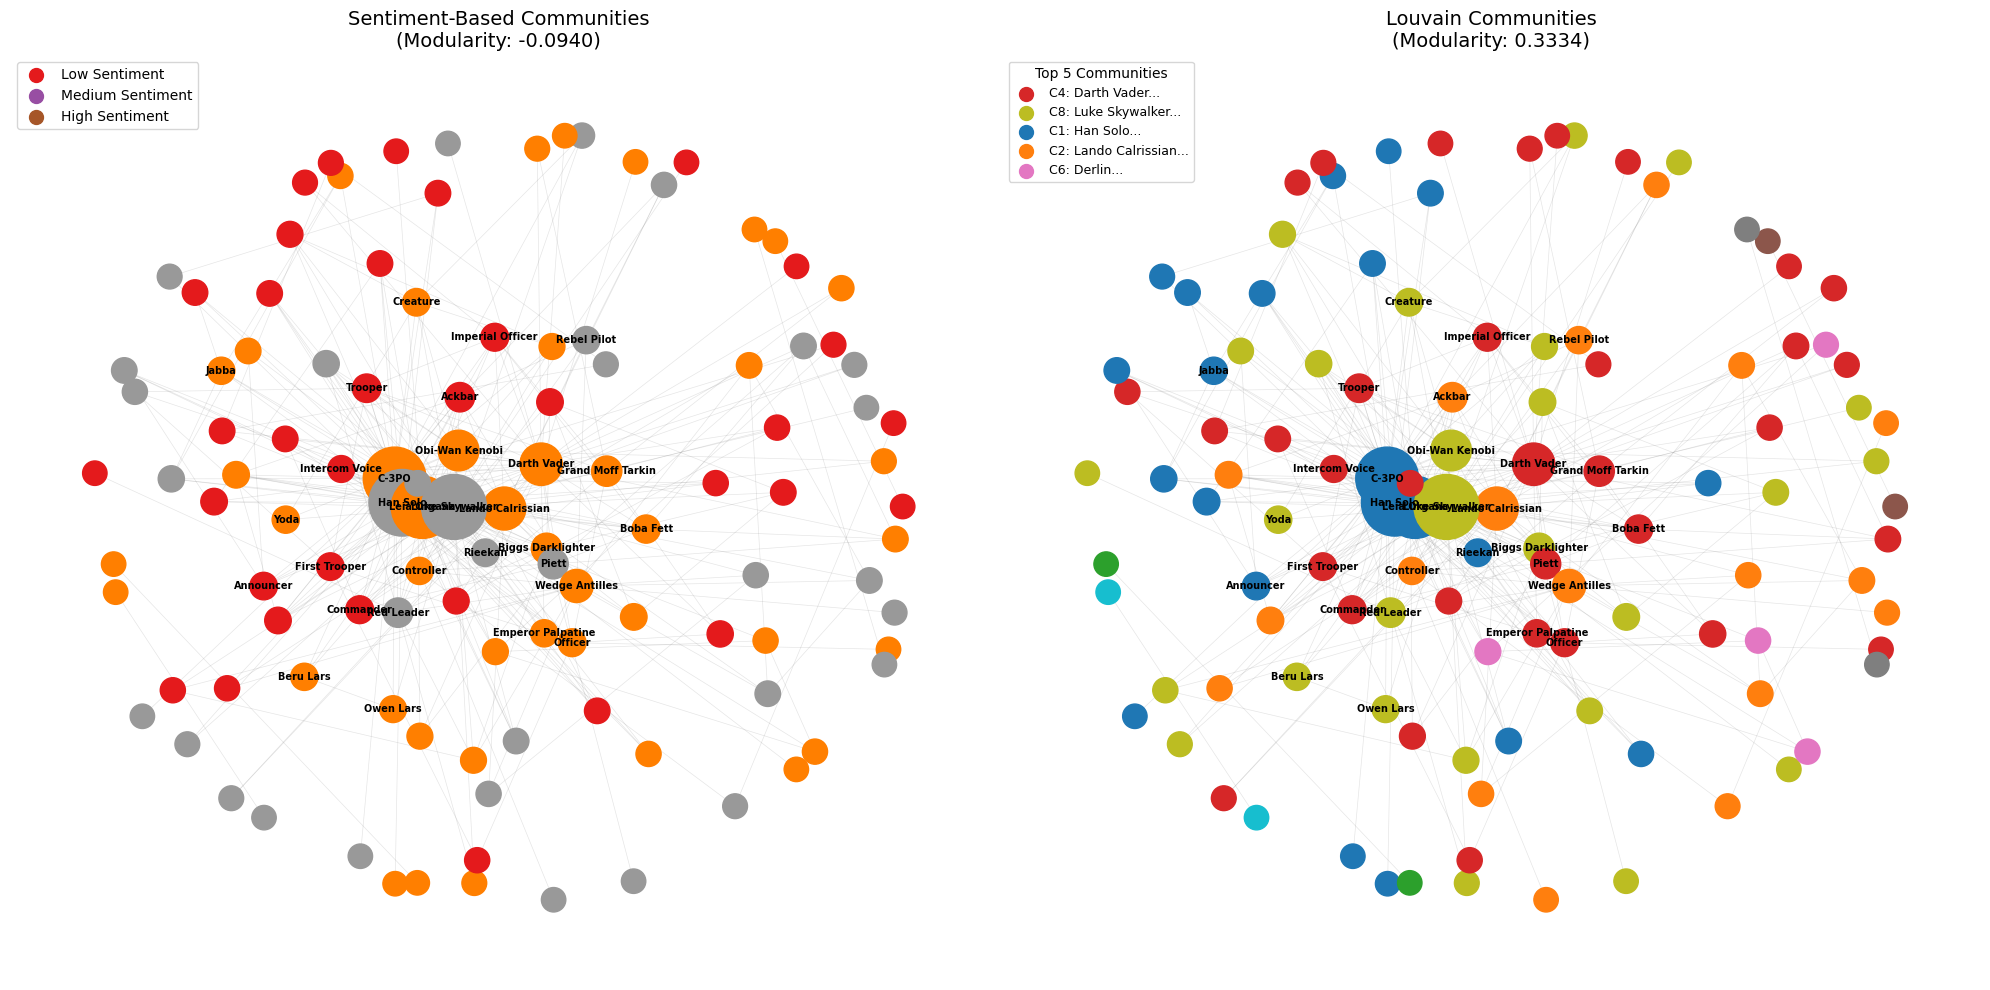

In [7]:
# Create node-to-community mappings
sentiment_node_community = {}
for comm_id, community in enumerate(sentiment_community_list):
    for node in community:
        sentiment_node_community[node] = comm_id

louvain_node_community = {}
for comm_id, community in enumerate(louvain_communities_result):
    for node in community:
        louvain_node_community[node] = comm_id


# Create colors for communities
def get_community_colors(node_community_map, n_communities):
    """Generate distinct colors for each community."""
    cmap = cm.get_cmap("tab10" if n_communities <= 10 else "tab20")
    colors = [cmap(node_community_map[node] / n_communities) for node in G.nodes()]
    return colors


# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax1 = axes[0]
sentiment_colors = get_community_colors(sentiment_node_community, 3)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color="gray", ax=ax1)
nodes1 = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[sentiment_node_community[n] for n in G.nodes()],
    node_size=node_sizes,
    cmap=cm.Set1,
    vmin=0,
    vmax=2,
    ax=ax1,
)
nx.draw_networkx_labels(G, pos, labels, font_size=7, font_weight="bold", ax=ax1)

ax1.set_title(
    f"Sentiment-Based Communities\n(Modularity: {modularity_sentiment:.4f})",
    fontsize=14,
)
ax1.axis("off")

# Add legend for sentiment communities
sentiment_labels = ["Low Sentiment", "Medium Sentiment", "High Sentiment"]
sentiment_cmap = cm.Set1
for i, label in enumerate(sentiment_labels):
    ax1.scatter([], [], c=[sentiment_cmap(i / 3)], s=100, label=label)
ax1.legend(loc="upper left", fontsize=10)

# ========== Louvain communities ==========
ax2 = axes[1]
n_louvain = len(louvain_communities_result)

nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color="gray", ax=ax2)
nodes2 = nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[louvain_node_community[n] for n in G.nodes()],
    node_size=node_sizes,
    cmap=cm.tab10,
    vmin=0,
    vmax=n_louvain - 1,
    ax=ax2,
)
nx.draw_networkx_labels(G, pos, labels, font_size=7, font_weight="bold", ax=ax2)

ax2.set_title(
    f"Louvain Communities\n(Modularity: {modularity_louvain:.4f})", fontsize=14
)
ax2.axis("off")

# Add legend for Louvain communities (top 5 by size)
sorted_communities = sorted(
    enumerate(louvain_communities_result), key=lambda x: len(x[1]), reverse=True
)
louvain_cmap = cm.tab10
for idx, (comm_id, community) in enumerate(sorted_communities[:5]):
    top_member = max(community, key=lambda x: degrees[x])
    ax2.scatter(
        [],
        [],
        c=[louvain_cmap(comm_id / (n_louvain - 1))],
        s=100,
        label=f"C{comm_id+1}: {top_member}...",
    )
ax2.legend(loc="upper left", fontsize=9, title="Top 5 Communities")

plt.tight_layout()
plt.show()

***

### Key Findings:

1. **Network Structure**: The Star Wars character network contains 113 characters with 313 weighted edges. The main characters (Han Solo, C-3PO, Leia Organa, Luke Skywalker) form the core of the network.

2. **Sentiment Distribution**: Character sentiment scores range from 3.54 to 6.25, with most characters clustered around 5.2-5.5.

3. **Community Detection Comparison**:
   - **Sentiment-Based**: Dividing characters by sentiment tertiles yields a negative modularity (-0.094), indicating that sentiment does not align well with the network's structural communities.
   - **Louvain Algorithm**: Detects 9 communities with positive modularity (0.333), revealing meaningful structural groups such as:
     - Imperial characters (Darth Vader, Grand Moff Tarkin, Piett)
     - Rebel heroes (Luke Skywalker, Obi-Wan Kenobi)
     - Main trio and associates (Han Solo, C-3PO, Leia Organa)
     - Rebel fleet (Lando Calrissian, Wedge Antilles, Ackbar)

The Louvain algorithm significantly outperforms sentiment-based clustering, confirming that character interactions in the movies form natural structural communities that don't necessarily correlate with their dialogue sentiment.
***

# 2) Bipartite network analysis

For each location $l \in L$ in the dataset, we maintained a dictionary structure containing:

- A set of characters $C_l = \{c_1, c_2, \ldots, c_n\}$ appearing in location $l$
- Appearance counts $w(c,l)$ representing the number of scenes in which character $c$ appears at location $l$
- A sentiment score $s(l)$ representing the emotional valence of location $l$

We formalized the character-location relationships as a bipartite graph $G = (C \cup L, E)$, where:

- $C$ is the set of character nodes
- $L$ is the set of location nodes with sentiment attribute $s(l)$
- $E \subseteq C \times L$ is the set of edges connecting characters to locations

Each edge $(c,l) \in E$ is weighted by the appearance count $w(c,l)$, representing the frequency of character $c$ appearing at location $l$.


## Bipartite network visualization

Node visual encoding followed these conventions:
- **Shape**: Circles for characters, squares for locations
- **Size**: Proportional to weighted degree $\deg_w(v) = \sum_{u \in N(v)} w(v,u)$, where $N(v)$ denotes the neighbors of node $v$
- **Color**: Mapped to sentiment scores using the RdYlGn (Red-Yellow-Green) colormap, where red indicates negative sentiment, yellow neutral, and green positive

Edge thickness was scaled proportionally to normalized weights.

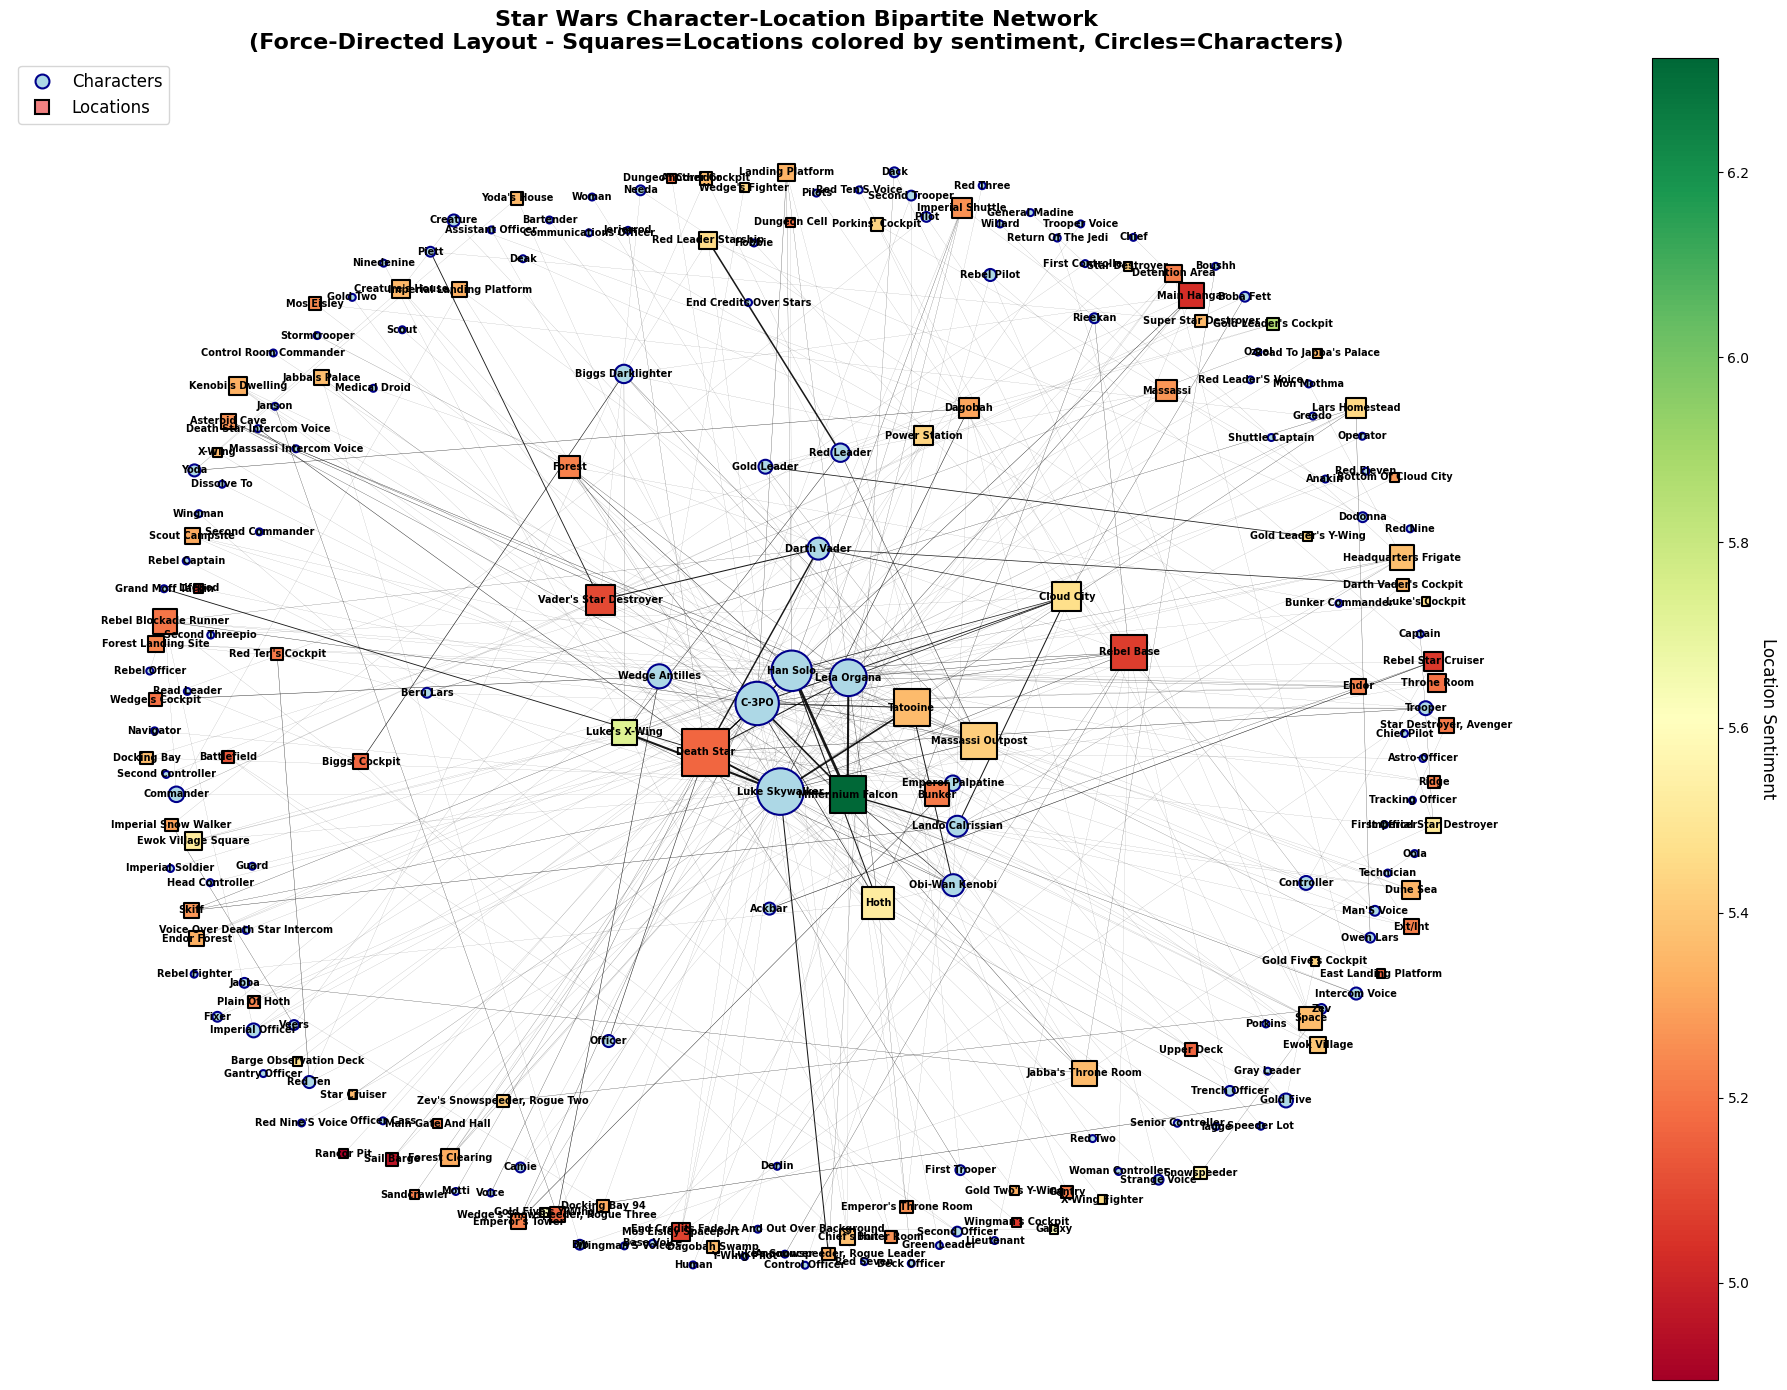

In [8]:
# read location_characters_dict from json location_characters_sentiment.json
with open("data/location_characters_with_sentiment.json", "r") as f:
    location_characters_dict = json.load(f)


# Create bipartite graph
G_bipartite = nx.Graph()

# Add nodes and edges
for location, data in location_characters_dict.items():
    G_bipartite.add_node(
        location, bipartite=0, sentiment=data["sentiment"], node_type="location"
    )

    for char, count in data["characters"].items():
        if char not in G_bipartite:
            G_bipartite.add_node(char, bipartite=1, node_type="character")
        G_bipartite.add_edge(location, char, weight=count)

# Separate nodes by type
char_nodes = [
    node for node, d in G_bipartite.nodes(data=True) if d["node_type"] == "character"
]
loc_nodes = [
    node for node, d in G_bipartite.nodes(data=True) if d["node_type"] == "location"
]

# Calculate degrees for filtering
location_degrees = {loc: G_bipartite.degree(loc) for loc in loc_nodes}

# Get sentiments and calculate min/max
sentiments = [
    G_bipartite.nodes[node]["sentiment"]
    for node in loc_nodes
    if G_bipartite.nodes[node]["sentiment"] is not None
]
min_sentiment = min(sentiments) if sentiments else 1.0
max_sentiment = max(sentiments) if sentiments else 10.0

# Get sentiments for location nodes (use mid value for None)
sentiments_for_colors = [
    (
        G_bipartite.nodes[node]["sentiment"]
        if G_bipartite.nodes[node]["sentiment"] is not None
        else (min_sentiment + max_sentiment) / 2
    )
    for node in loc_nodes
]

# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Use spring layout for bipartite network
pos_bipartite = nx.spring_layout(
    G_bipartite, k=1.5, iterations=50, seed=42, weight="weight"
)

# Node sizes
char_node_sizes = [G_bipartite.degree(node) * 25 for node in char_nodes]
loc_node_sizes = [G_bipartite.degree(node) * 40 for node in loc_nodes]

# Draw character nodes (circles)
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=char_nodes,
    node_size=char_node_sizes,
    node_color="lightblue",
    edgecolors="darkblue",
    linewidths=1.5,
    ax=ax,
)

# Draw location nodes (squares) with sentiment-based colors
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=loc_nodes,
    node_size=loc_node_sizes,
    node_shape="s",
    node_color=sentiments_for_colors,
    cmap="RdYlGn",
    vmin=min_sentiment,
    vmax=max_sentiment,
    edgecolors="black",
    linewidths=1.5,
    ax=ax,
)

# Draw edges
edges_bi = G_bipartite.edges()
weights_bi = [G_bipartite[u][v]["weight"] for u, v in edges_bi]
max_weight_bi = max(weights_bi) if weights_bi else 1
edge_widths_bi = [w / max_weight_bi * 2 for w in weights_bi]

nx.draw_networkx_edges(
    G_bipartite,
    pos_bipartite,
    width=edge_widths_bi,
    alpha=0.9,
    edge_color="black",
    ax=ax,
)

# Draw all character labels
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels={node: node if node in char_nodes else "" for node in G_bipartite.nodes()},
    font_size=7,
    font_weight="bold",
    ax=ax,
)

# Draw ALL location labels with same font size
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels={node: node if node in loc_nodes else "" for node in G_bipartite.nodes()},
    font_size=7,
    font_color="black",
    font_weight="bold",
    ax=ax,
)

# Add colorbar for sentiment
sm = plt.cm.ScalarMappable(
    cmap="RdYlGn", norm=plt.Normalize(vmin=min_sentiment, vmax=max_sentiment)
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Location Sentiment", rotation=270, labelpad=20, fontsize=12)

# Create custom legend to avoid overlap
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Characters",
        markerfacecolor="lightblue",
        markeredgecolor="darkblue",
        markersize=10,
        markeredgewidth=1.5,
    ),
    Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        label="Locations",
        markerfacecolor="lightcoral",
        markeredgecolor="black",
        markersize=10,
        markeredgewidth=1.5,
    ),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=12)

ax.set_title(
    "Star Wars Character-Location Bipartite Network\n(Force-Directed Layout - Squares=Locations colored by sentiment, Circles=Characters)",
    fontsize=16,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.show()

> Figure: Bipartite network of characters and locations in the Star Wars original trilogy.
***

## Bipartite network sentiment statistics

In [9]:
print("Location sentiment statistics:")
print(f"Number of characters: {G_bipartite.number_of_nodes() - len(loc_nodes)}")
print(f"Number of locations: {len(loc_nodes)}")
print(f"Number of connections: {G_bipartite.number_of_edges()}")
print(f"Min sentiment: {min_sentiment:.3f}, Max sentiment: {max_sentiment:.3f}")

Location sentiment statistics:
Number of characters: 128
Number of locations: 94
Number of connections: 378
Min sentiment: 4.895, Max sentiment: 6.324


***

### Sentiment Projection from Locations to Characters

To transfer emotional context from locations to characters, we employed a weighted averaging scheme. For each character $c \in C$, we computed a projected sentiment score $S(c)$ based on all locations $L_c \subseteq L$ to which the character is connected:

$$S(c) = \frac{\sum_{l \in L_c} w(c, l) \cdot s(l)}{\sum_{l \in L_c} w(c, l)}$$

where:

- $L_c = \{l \in L : (c, l) \in E\}$ is the set of locations visited by character $c$
- $w(c,l)$ is the edge weight (appearance count)
- $s(l)$ is the sentiment score of location $l$

This formulation ensures that characters appearing more frequently in certain locations are more strongly influenced by those locations' sentiment scores. Characters with no valid location sentiments were assigned null values and excluded from sentiment-based analyses.

## Bipartite Graph Projection to Character Network

To analyze character relationships mediated by shared locations, we projected the bipartite graph onto the character space, creating a unipartite character network $G' = (C, E')$.

For each location $l \in L$ with connected characters $C_l = \{c_1, c_2, \ldots, c_n\}$, we created edges between all character pairs $(c_i, c_j)$ where $i \neq j$. The weight of each projected edge represents the strength of co-occurrence through shared locations.

The edge weight between characters $c_i$ and $c_j$ through location $l$ was computed as:

$$w_l(c_i, c_j) = \min(w(c_i, l), w(c_j, l))$$

This conservative estimate uses the minimum appearance count, ensuring that edge weights reflect genuine co-presence rather than independent visits to the same location.

When multiple locations connect the same character pair, we summed their contributions:

$$W(c_i, c_j) = \sum_{l \in L_{ij}} w_l(c_i, c_j)$$

where $L_{ij} = \{l \in L : (c_i, l) \in E \wedge (c_j, l) \in E\}$ is the set of locations shared by both characters.

The projection algorithm transforms spatial co-occurrence into direct character relationships, enabling network analysis techniques such as community detection and centrality measures on the character space while preserving the sentiment information inherited from locations.



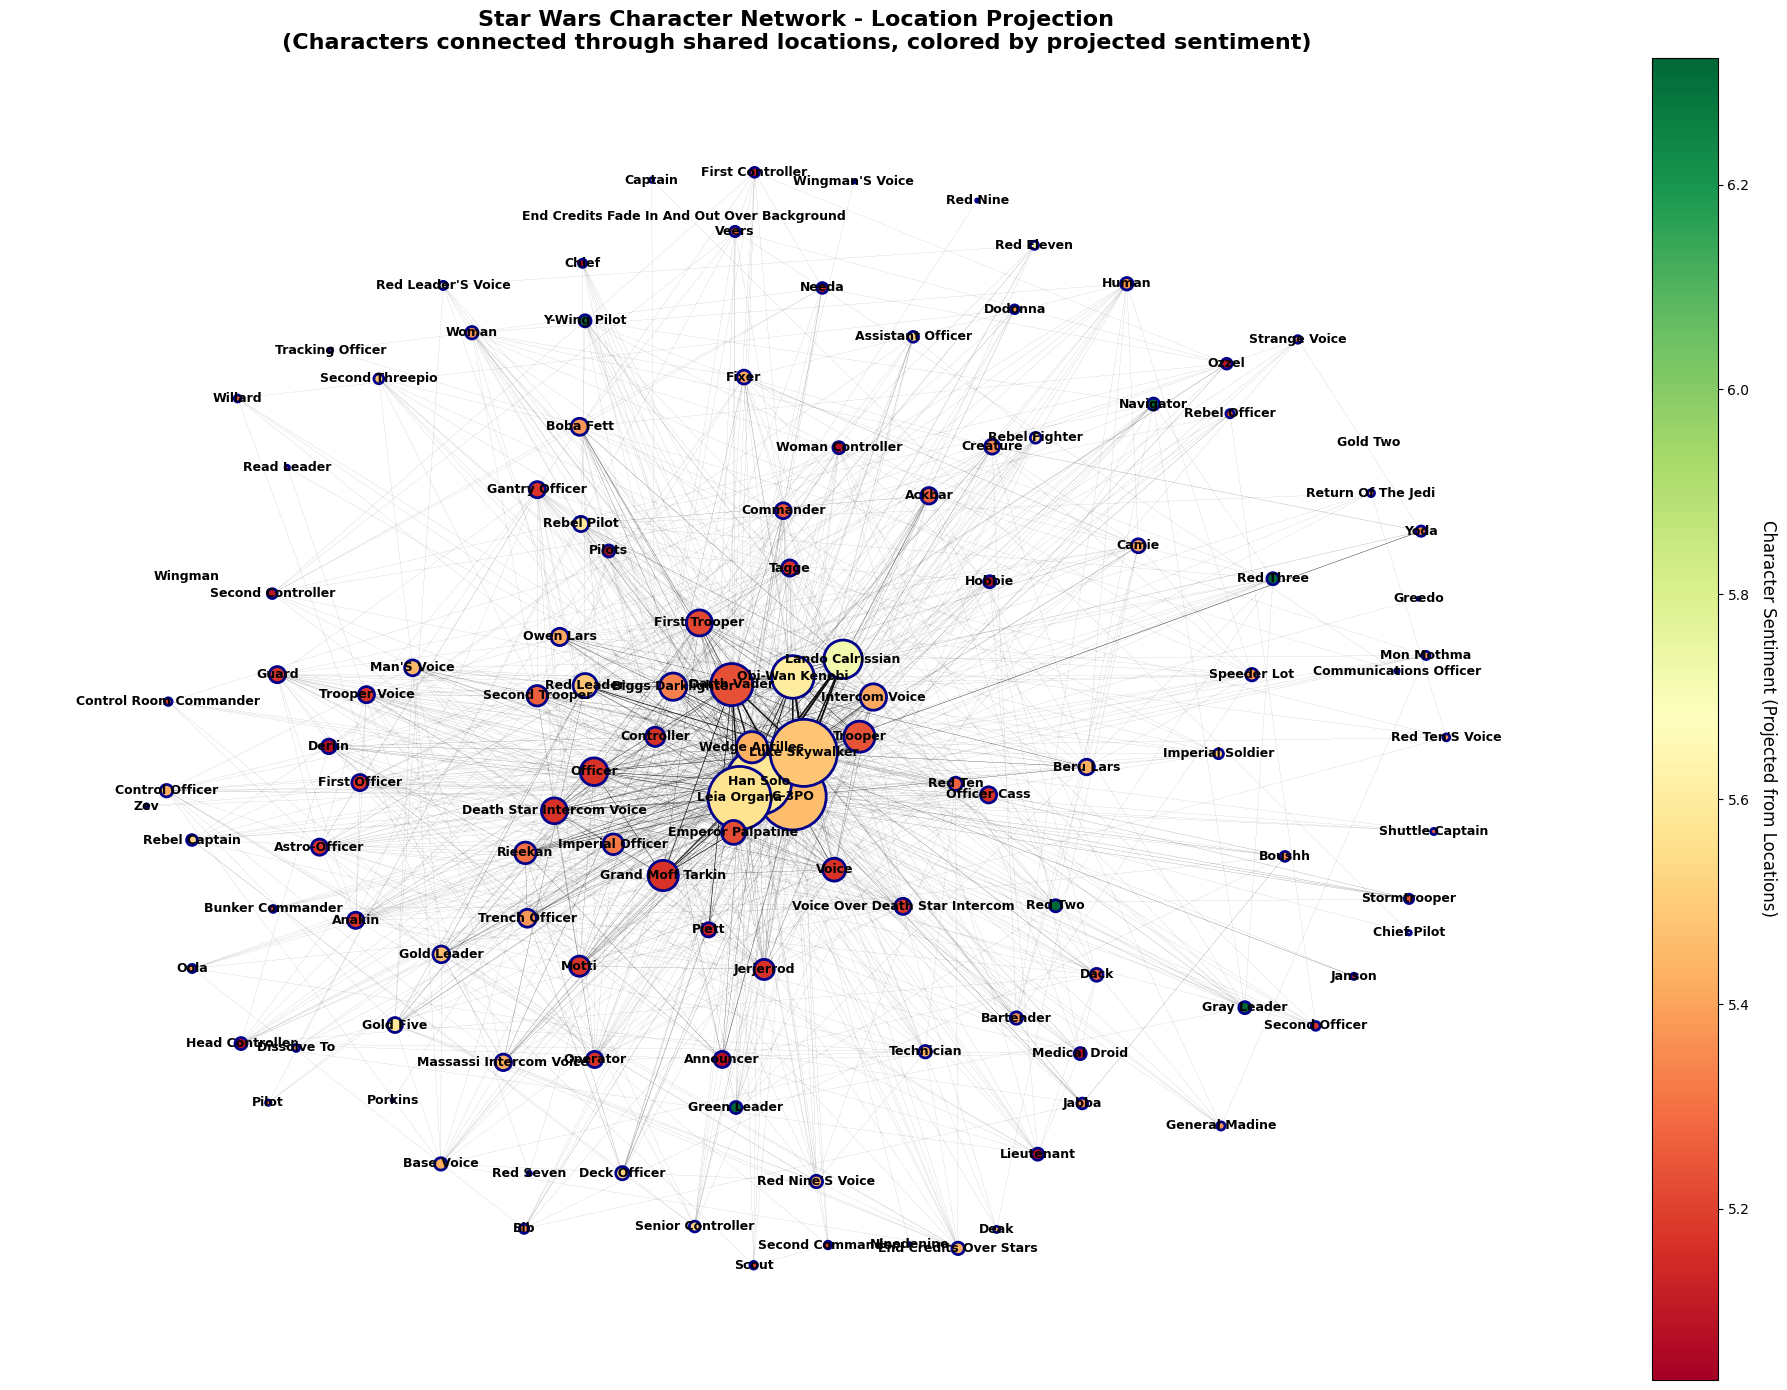

In [10]:
# get character sentiments based on connected locations sentiments
character_sentiments_subset = {}

for char in char_nodes:
    connected_locations = [n for n in G_bipartite.neighbors(char) if n in loc_nodes]
    if not connected_locations:
        character_sentiments_subset[char] = None
        continue

    weighted_sum = 0
    total_weight = 0
    for loc in connected_locations:
        weight = G_bipartite[char][loc]["weight"]
        sentiment = G_bipartite.nodes[loc]["sentiment"]
        if sentiment is not None:
            weighted_sum += sentiment * weight
            total_weight += weight

    if total_weight > 0:
        character_sentiments_subset[char] = weighted_sum / total_weight
    else:
        character_sentiments_subset[char] = None


# Create character-to-character projection graph
G_projection = nx.Graph()

# Add all character nodes with projected sentiments
for char in char_nodes:
    G_projection.add_node(char, sentiment=character_sentiments_subset[char])

# For each location, connect all pairs of characters that appear in it
for location in loc_nodes:
    # Get all characters connected to this location
    chars_in_location = [n for n in G_bipartite.neighbors(location) if n in char_nodes]

    # Connect all pairs of characters
    for i in range(len(chars_in_location)):
        for j in range(i + 1, len(chars_in_location)):
            char1 = chars_in_location[i]
            char2 = chars_in_location[j]

            # Get weights (how many times each character appears in this location)
            weight1 = G_bipartite[char1][location]["weight"]
            weight2 = G_bipartite[char2][location]["weight"]

            # Edge weight is the minimum of the two (conservative estimate of co-occurrence)
            edge_weight = min(weight1, weight2)

            # If edge already exists, add to its weight
            if G_projection.has_edge(char1, char2):
                G_projection[char1][char2]["weight"] += edge_weight
            else:
                G_projection.add_edge(char1, char2, weight=edge_weight)

# Get character sentiments for coloring
char_sentiments_proj = [
    (
        G_projection.nodes[node]["sentiment"]
        if G_projection.nodes[node]["sentiment"] is not None
        else None
    )
    for node in G_projection.nodes()
]
char_sentiments_proj_clean = [s for s in char_sentiments_proj if s is not None]

min_sentiment_proj = (
    min(char_sentiments_proj_clean) if char_sentiments_proj_clean else 1.0
)
max_sentiment_proj = (
    max(char_sentiments_proj_clean) if char_sentiments_proj_clean else 10.0
)

char_sentiments_for_colors_proj = [
    (
        G_projection.nodes[node]["sentiment"]
        if G_projection.nodes[node]["sentiment"] is not None
        else (min_sentiment_proj + max_sentiment_proj) / 2
    )
    for node in G_projection.nodes()
]

# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Use spring layout
pos_projection = nx.spring_layout(
    G_projection, k=1.5, iterations=50, seed=42, weight="weight"
)

# Node sizes based on degree
node_sizes = [
    G_projection.degree(node, weight="weight") * 5 for node in G_projection.nodes()
]

# Draw character nodes with projected sentiment colors
nx.draw_networkx_nodes(
    G_projection,
    pos_projection,
    node_size=node_sizes,
    node_color=char_sentiments_for_colors_proj,
    cmap="RdYlGn",
    vmin=min_sentiment_proj,
    vmax=max_sentiment_proj,
    edgecolors="darkblue",
    linewidths=2,
    ax=ax,
)

# Draw edges
edges_proj = G_projection.edges()
weights_proj = [G_projection[u][v]["weight"] for u, v in edges_proj]
max_weight_proj = max(weights_proj) if weights_proj else 1
edge_widths_proj = [w / max_weight_proj * 4 for w in weights_proj]

nx.draw_networkx_edges(
    G_projection,
    pos_projection,
    width=edge_widths_proj,
    alpha=0.9,
    edge_color="black",
    ax=ax,
)

# Draw labels
nx.draw_networkx_labels(
    G_projection,
    pos_projection,
    font_size=9,
    font_weight="bold",
    ax=ax,
)

# Add colorbar for sentiment
sm = plt.cm.ScalarMappable(
    cmap="RdYlGn", norm=plt.Normalize(vmin=min_sentiment_proj, vmax=max_sentiment_proj)
)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(
    "Character Sentiment (Projected from Locations)",
    rotation=270,
    labelpad=20,
    fontsize=12,
)

ax.set_title(
    "Star Wars Character Network - Location Projection\n(Characters connected through shared locations, colored by projected sentiment)",
    fontsize=16,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.show()

> Figure: Locations projected onto characters and sentiment of locations spreaded between them.

---

## Projection graph statistics

In [11]:
print(f"Number of characters: {G_projection.number_of_nodes()}")
print(f"Number of connections: {G_projection.number_of_edges()}")
print(
    f"Min sentiment: {min_sentiment_proj:.3f}, Max sentiment: {max_sentiment_proj:.3f}"
)

# mean of the projected character sentiments
valid_sentiments = [s for s in char_sentiments_proj if s is not None]
mean_sentiment = np.mean(valid_sentiments) if valid_sentiments else None
print(
    f"Mean projected character sentiment: {mean_sentiment:.3f}"
    if mean_sentiment is not None
    else "Mean projected character sentiment: N/A"
)

Number of characters: 128
Number of connections: 1141
Min sentiment: 5.033, Max sentiment: 6.324
Mean projected character sentiment: 5.356


# 3) Sentiment Analysis